# Basics of the Particle Image Velocimetry (PIV) 
Using open source PIV software, OpenPIV (http://www.openpiv.net) written with the great help of Python, Numpy, Scipy (http://www.scipy.org) and runs online thanks to the great MyBinder project.

## What is it about? Particle Image Velocimetry (PIV)
From Wikipedia: "Particle image velocimetry (PIV) is an optical method of flow visualization used in education and research. It is used to obtain instantaneous velocity measurements and related properties in fluids. The fluid is seeded with tracer particles which, for sufficiently small particles, are assumed to faithfully follow the flow dynamics (the degree to which the particles faithfully follow the flow is represented by the Stokes number). The fluid with entrained particles is illuminated so that particles are visible. The motion of the seeding particles is used to calculate speed and direction (the velocity field) of the flow being studied."
    read more on http://en.wikipedia.org/wiki/Particle_image_velocimetry
    
Particle Image Velocimetry (PIV) is a non-intrusive state-of-the-art technique for flow measurements (e.g.: Raffel et al., 2007, Adrian, 1991). The PIV technique is based on image recording of the illuminated flow field using seeding particles. The technique is based on illuminating the particles in a plane by forming a coherent light sheet. The light scattered by the particles is recorded on a sequence of image frames. The displacement of the particle images between two consecutive light pulses is determined through evaluation of the PIV recordings and by applying a spatial cross-correlation function as implemented by the OpenPIV resulting with a two dimensional two component velocity field. 
In practice, small tracer particles, common sized are in the order of 10-100 microns, are introduced to the flow. The flow is illuminated twice by means of a laser light sheet forming a plane where the camera is focused on. The time delay between the pulses depends on the mean velocity and the image magnification. It is assumed that the tracer particles follow the local flow velocity between the two consecutive illuminations. The light scattered from the tracer particles is imaged via an optical lens on a digital camera. 
The images, acquired as pairs correspond to the two laser pulses, are than correlated using a cross-correlation function and image processing tools in order to provide the velocity field. 
The effectiveness of the measurement results strongly depends on a large number of parameters such as particles concentration, size distribution and shape, illumination source, recording device, and synchronization between the illumination, acquisition and recording systems (Huang et al., 1997). An appropriate choice of the different parameters of the cross correlation analysis (e.g., interrogation area, time between pulses, scaling) will influence the results accuracy. 
    read more about PIV in the following chapters: Gurka and Kit, in Handbook of Environmental Fluid Mechanics, CRC Press, 2014 http://www.crcnetbase.com/doi/abs/10.1201/b13691-39
    or Taylor, Gurka and Liberzon "Particle Image Velocimetry for Biological Mechanics" in the Handbook of Imaging in Biological Mechanics, CRC Press, 2015, http://www.crcpress.com/product/isbn/9781466588134


### Open source software to learn the basics
        
In principle velocimetry is a method to find out the velocity field of the moving fluid. 'Particle' image velocimetry is the way to get velocity field from images of small particles, called tracers. The basic principle is to use two images of the same particles with a small time delay between them. For that purpose, typically two laser shots are created and two images are taken. 

This tutorial will follow the most simple analysis path from the two images to the velocity field and some post-analysis. We will use one of many open source packages, the open source particle image velocimetry http://www.openpiv.net

In [1]:
# Let's take two images
# import the standard numerical and plotting packages

from pylab import *
from skimage.io import imread

We have downloaded some sample images from PIV challenge, 
see http://www.pivchallenge.org/pub/#e  or another standard PIV images project: http://www.piv.jp/down/image05e.html

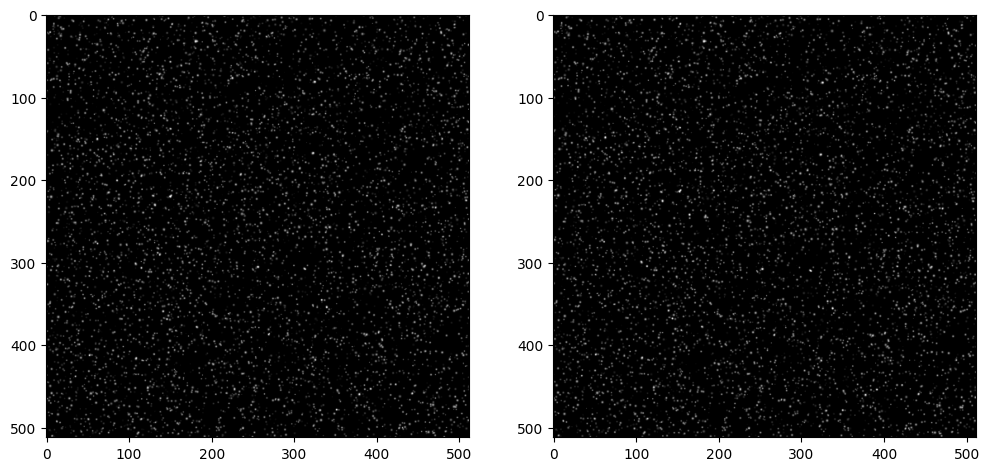

In [2]:
# load the images: 
a = imread('http://www.pivchallenge.org/pub/B/B005_1.tif')
b = imread('http://www.pivchallenge.org/pub/B/B005_2.tif')

figure(figsize=(12,10))
subplot(1,2,1)
imshow(a,cmap=cm.gray)
subplot(1,2,2)
imshow(b,cmap=cm.gray)
# imshow(c_[a,b],cmap=cm.gray)

The two images showing the positions of the particles at two time steps. We can analyse small regions of interest, called interrogation windows.
typically we can start with the size of 32 x 32 pixels or smaller. Until recently, the fast algorithms used powers of 2, so the historical sizes are 
always powers of 2: 8, 16, 32, 64, 128, ...

let's take the first top left windows from each image

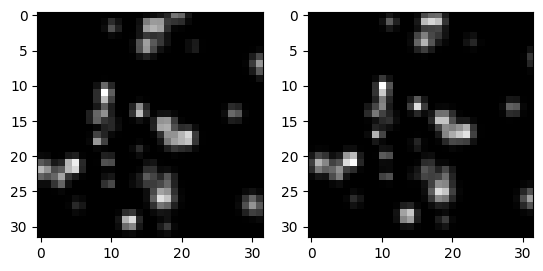

In [3]:
ia = a[:32,:32].copy()
ib = b[:32,:32].copy()

# just for the test, you can try also a "known" result
# ib = roll(ia,2,axis=1).copy()


figure()
subplot(1,2,1)
imshow(ia,cmap=cm.gray)
subplot(1,2,2)
imshow(ib,cmap=cm.gray)

We can see that the bright pixels moved between the two frames.
we can find out the distance that all the particles moved between frame A and frame B using 
the principles of least squares or correlations, but let's first try to get it manually
if we shift the window IA by some pixels to the right and subtract from IB the shifted IA, 
we shall see how good the shift predicts the real displacement between the two 


Text(0.5, 1.0, 'Without shift')

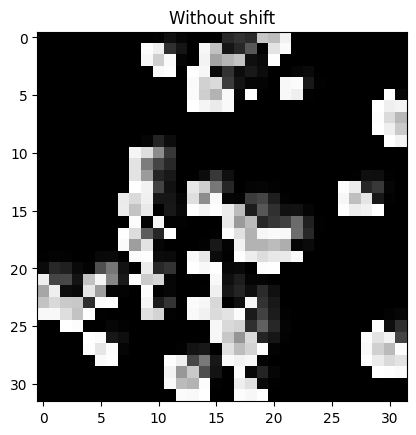

In [4]:
imshow(ib-ia,cmap=cm.gray)
title('Without shift')

Text(0.5, 1.0, 'Difference when IA has been shifted by 1 pixel')

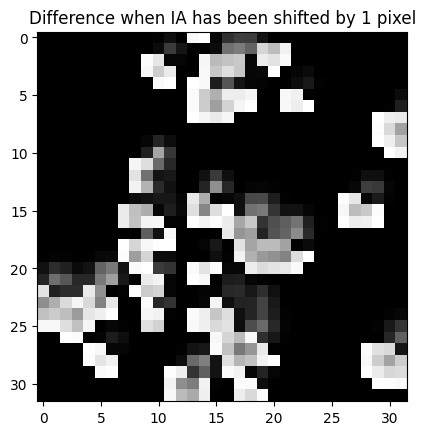

In [5]:
imshow(ib-roll(ia,1,axis=0),cmap=cm.gray)
title('Difference when IA has been shifted by 1 pixel')

Let's try to find the best shift algorithmically: shift and calculated the sum of squared differences the minimum is the best shift

In [6]:
def match_template(img, template,maxroll=8):
    mindist = float('inf')
    idx = (-1,-1)
    for y in range(maxroll):
        for x in range(maxroll):
        #calculate Euclidean distance
            dist = sqrt(sum(square(template - roll(roll(img,x,axis=0),y,axis=1))))
            if dist < mindist:
                mindist = dist
                idx = (x,y)
                
    return [mindist, idx]

In [7]:
# let's test that it works indeed by manually rolling (shifting circurlarly) the same image
match_template(ia,roll(ia,2,axis=0))

[0.0, (2, 0)]

In [8]:
# indeed, when we find the correct shift, we got zero distance. it's not so in real images:
mindist, idx = match_template(ib,ia)
print('Minimal distance = %f' % mindist)
print('idx = %d, %d' % idx)

Minimal distance = 171.659547
idx = 1, 0


We can draw this as a vector of velocity: $u = \Delta X$ pixels/$\Delta t$, $v =\Delta Y$ pixels/$\delta$ t where $\delta$ t is the time interval (delay) between the  two images (or two laser pulses)

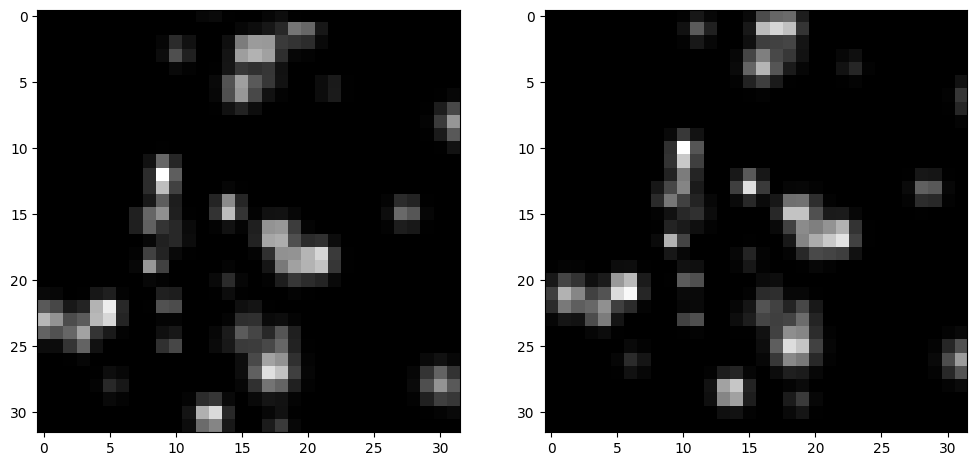

In [9]:
figure(figsize=(12,10))
subplot(1,2,1)
imshow(roll(roll(ia,idx[0],axis=0),idx[1],axis=1),cmap=cm.gray)
subplot(1,2,2)
imshow(ib,cmap=cm.gray)

Well, maybe it's not the best match, but it is already better than nothing. 
the problem now is that manually shifting each image and repeating the loop many times is impractical
the same principle of finding the right shift one can get by using a different template matching 
principle, based on the property called cross-correlation (cross because we use two different images)
in short this is an efficient computational algorithm to find out the right shift. 
you can see more details here: http://paulbourke.net/miscellaneous/correlate/

In [10]:
from scipy.signal import correlate2d
c = correlate2d(ia-ia.mean(),ib-ib.mean())
# not it's twice bigger than the original windows, as we can shift ia by maximum it's size horizontally and vertically
print('Size of the correlation map %d x %d' % c.shape)

Size of the correlation map 63 x 63


Text(0.5, 0.92, 'Correlation map - peak is the most probable shift')

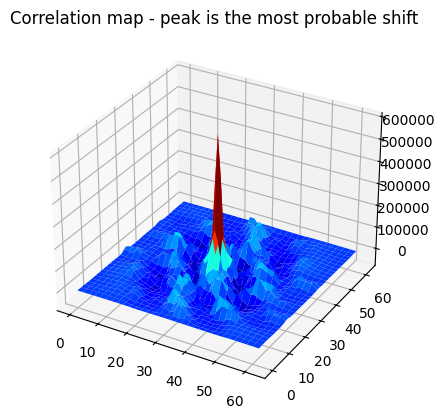

In [11]:
# let's see how the correlation map looks like:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cx,cy = meshgrid(range(c.shape[0]), range(c.shape[1]))

ax.plot_surface(cx,cy,c,cmap=cm.jet, linewidth=0.2)
title('Correlation map - peak is the most probable shift')

i = 32, j= 30


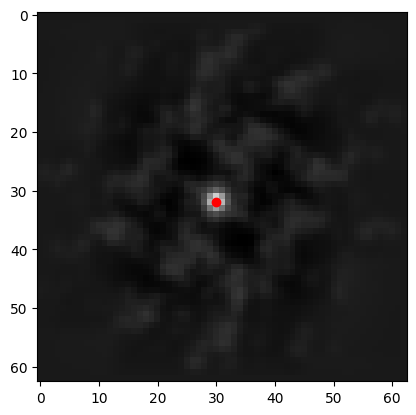

In [12]:
# let's see the same correlation map, from above
imshow(c, cmap='gray')

i,j = np.unravel_index(c.argmax(), c.shape)

print('i = {}, j= {}'.format(i,j))

plot(j,i,'ro')

maybe this is confusing, but the image of the correlation map shows the same result - we need to shift the window A the the best possible correlation between the two windows. if there would be no shift, the result would be 31,31 - the center of symmetry.


We can get the first velocity field by repeating this analysis for all small windows let's take 32 x 32 pixels windows from each image and do the loop


Now you can take our online IPython notebook and process any pairs of images yourself, on the cloud, http://github.com/openpiv/openpiv-python-example
    
or download the OpenPIV and try it yourself : https://github.com/OpenPIV
   